# Building an Agent to Play Atari games using Deep Q Network (DQN)

# Introduction
Short, simple DQN algorithm to play [MsPacman-V0]((https://gym.openai.com/envs/MsPacman-v0/)) from the open ai gym

Disclosure: Most of the code was taken from chapter 8 of "Deep Reinforcement Learning with Python - Second Edition by Sudharsan Ravichandiran", with some alterations and extension
  
Original paper by V. Mnih et al., "Playing Atari with Deep Reinforcement Learning": [arXiv:1312.5602](https://arxiv.org/pdf/1312.5602v1.pdf)

    

    
    

# Libraries

In [2]:
#Avoid tensorflow debug output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
    #0 = all messages are logged (default behavior)
    #1 = INFO messages are not printed
    #2 = INFO and WARNING messages are not printed
    #3 = INFO, WARNING, and ERROR messages are not printed

#Supporting libraries
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Pre-Processing 
Definition the state pre-processor, trims, convert to grayscale and blend images to feed to the agent

In [4]:
class PreProcessMSPacman:
        #Constructor
        def __init__(self, num_blended_images):                           
            self.image_buffer = deque(maxlen=num_blended_images)  
            self.mspacman_color = np.array([210, 164, 74]).mean()
    
        def __rgb2gray(self, rgb):
            return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

        def __preprocess_image_ori(self, state):                
            image = state[1:176:2, ::2]             # Crop and downsize            
            image = image.mean(axis=2)              # Convert to greyscale            
            image[image== self.mspacman_color] = 0  # Improve contrast by making pacman white            
            image = (image - 128) / 128 - 1         # Normalize from -1 to 1.
                
            # Reshape
            image = np.expand_dims(image.reshape(88,80,1), axis=0) 
            return image
        
        def __preprocess_image_ext(self, state):    
            #Process the image            
            image = state[1:171]           # Crop the image (170, 160)
            image = self.__rgb2gray(image) # Convert to greyscale                               
            image = cv2.resize(image, None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_CUBIC)  # Reduce to 0.5 (85, 80) of the scale
            
            # Reshape
            image = np.expand_dims(image.reshape(85,80,1), axis=0) 
            return image
            
        def __blend_image(self, state):
            #Append the new image to the array
            self.image_buffer.append(state)    
            
            #Calculate the average (and expand dimension)
            avg_image = np.zeros_like(state)
            
            #Iterate over all the images
            for image in self.image_buffer:
                avg_image += image            
            return avg_image / len(self.image_buffer)
        
        def apply(self, state):        
            state_processed = self.__preprocess_image_ori(state)
            state_processed = self.__blend_image(state_processed)
            return state_processed


# Agent

In [3]:
class DQN:
        #Constructor
        def __init__(self, state_size, action_size, gamma=0.95, epsilon=0.1, update_rate=1000):            
            self.state_size = state_size               #Input Size
            self.action_size = action_size             #Action Size
            self.replay_buffer = deque (maxlen = 5000) #Replay Buffer
            self.gamma = gamma                         #Discount rate
            self.epsilon = epsilon                     #Exploration rate
            self.update_rate = update_rate             #Update every timesteps
            self.main_network = self.build_network()   #Build main network
            self.target_network = self.build_network() #Build target network           
            
            #Copy the weights of the main network to the target network 
            self.target_network.set_weights(self.main_network.get_weights())
            
            
        #Define the model
        def build_network(self):            
            model = Sequential()
            model.add(Conv2D( filters=32, kernel_size = (8,8), strides = 4, padding='same', input_shape = self.state_size))
            model.add(Activation('relu'))
            model.add(Conv2D( filters=64, kernel_size = (4,4), strides = 2, padding='same'))
            model.add(Activation('relu'))
            model.add(Conv2D( filters=64, kernel_size = (3,3), strides = 1, padding='same'))
            model.add(Activation('relu'))
            model.add(Flatten())
            model.add(Dense(512, activation = 'relu'))
            model.add(Dense(self.action_size, activation = 'linear'))
            
            #Compile the model
            model.compile(loss='mse', optimizer = Adam())
            
            return model
        
        #Store transitions information in the replay buffer
        def store_transition(self, state, action, rewards, next_state, done):
            self.replay_buffer.append((state, action, rewards, next_state, done))

        #Select next action (epsilon greedy strategy)
        def epsilon_greedy(self, state):        
            if random.uniform(0.0, 1.0) < self.epsilon:
                return np.random.randint(self.action_size)                    
            Q_values = self.main_network.predict(state)
            return np.argmax(Q_values)
        
        #Defining the training
        def train(self, batch_size):            
            #Check the repleay buffer contains enough samples  
            if (len(self.replay_buffer) < batch_size):
                return                
            
            #Sample
            mini_batch= random.sample(self.replay_buffer, batch_size)
            
            #Create training batch
            state_batch, q_values_batch = [], []
            for state, action, reward, next_state, done in mini_batch:
                if not done:
                    target_Q = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))
                else:
                    target_Q = reward
                #Compute the values using the main network             
                Q_values = self.main_network.predict(state)
                Q_values[0][action] = target_Q
            
                #Prepare training batch
                state_batch.append(state[0])
                q_values_batch.append(Q_values[0])
                
            #Train the main network
            self.main_network.fit( np.array(state_batch),
                                   np.array(q_values_batch),
                                   batch_size = batch_size,
                                   epochs=1, verbose = 0)                
            
        #Updating the target network
        def update_target_network(self, timestep):
            if (timestep % self.update_rate ==  0):
                self.target_network.set_weights(self.main_network.get_weights())
                #print("Target network updated")                
        

 # Environment

In [4]:
#Import the environment
env = gym.make("MsPacman-v0")

state_size           = (88, 80, 1)        # Set the state size (cropped & resized)
action_size          = env.action_space.n # Get the number of actions
num_episodes         = 100                # Number of episodes to run
max_timesteps        = 2000               # Max timesteps per episode
skip_timesteps       = 90                 # Skip the start of the game (waiting) 
batch_size           = 8                  # Training batch size
num_images_blended   = 3                  # Number of images to blend (states)
delay_training_steps = 10000              # Start Training after x timesteps 
penalty              = 0                  # The penanlty for idle action
render               = False              # Control env rendering

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


In [5]:
def run():       
        
    # To run GUI event loop
    plt.ion()

    # Creating sub plots
    figure, _ = plt.subplots(figsize=(10, 8))
    plt.title("MsPacman-V0", fontsize=20)
    plt.xlabel("Episode")
    plt.ylabel("Return")    
    x = []
    y = []
    y_avg = []

    #Create DQN Agent & State Pre-Processor
    dqn = DQN(state_size, action_size, update_rate=1000)
    preprocess = PreProcessMSPacman(num_images_blended)

    #Variables
    done = False
    total_timesteps =0        
    reward_sum = 0

    #Espidodes    
    for episode_num in range(1, 1+num_episodes):
        start_time_sec = time.time()
        reward_episode = 0

        #Reset the game
        state = env.reset()    

        # Skip the start of each game waiting
        for skip in range(skip_timesteps):
            env.step(0)

        #Pre-process the state
        state = preprocess.apply(state)
        
        #Time steps on a on the espisode
        for timestep in range(max_timesteps):
            #Increment the total time step
            total_timesteps +=1

            #Update the target network
            dqn.update_target_network(total_timesteps)                
            
            #Render the environment
            if render:
                env.render()        
            
            #Agent select the next action base on the current state 
            action = dqn.epsilon_greedy(state)

            #Perform the selected action
            next_state, reward, done, _ = env.step(action)
            
            #Penalize for no reward 
            reward -= penalty

            #Preprocess the next_state
            next_state = preprocess.apply(next_state)        

            #Store the transition
            dqn.store_transition(state, action, reward, next_state, done)
            
            #Update the current state
            state = next_state

            #Update episode reward
            reward_episode += reward
            
            #Check if episode is done
            if done:
                #Plot
                x.append(episode_num)
                y.append(reward_episode)
                reward_sum += reward_episode                
                reward_avg = reward_sum/(episode_num)                
                y_avg.append(reward_avg)                
                figure.clf()
                plt.plot(x, y, marker="s", label="reward x episode")                                    
                plt.plot(x, y_avg, marker="o", label="reward avg")             
                plt.legend()
                figure.canvas.draw()
                figure.canvas.flush_events()            
                total_time_sec = time.time() - start_time_sec                
                print('Episode {:d}, reward {:4.2f}, timesteps {:d}, reward_avg {:4.2f}, reward sum {:4.2f}total timesteps {:d}, time {:3.0f} seconds'.format(
                      episode_num, 
                      reward_episode,
                      timestep,      
                      reward_avg,
                      reward_sum,
                      total_timesteps,
                      total_time_sec))
                break
                
            #Delay training
            if (total_timesteps > delay_training_steps):                
                dqn.train(batch_size)
                
    env.close()       
        

# Run
Run the agent (optional with profiler)

Episode 1, reward 250.00, timesteps 373, reward_avg 250.00, reward sum 250.00total timesteps 374, time   7 seconds
Episode 2, reward 210.00, timesteps 608, reward_avg 230.00, reward sum 460.00total timesteps 983, time  11 seconds
Episode 3, reward 260.00, timesteps 625, reward_avg 240.00, reward sum 720.00total timesteps 1609, time  10 seconds
Episode 4, reward 230.00, timesteps 461, reward_avg 237.50, reward sum 950.00total timesteps 2071, time   8 seconds
Episode 5, reward 310.00, timesteps 440, reward_avg 252.00, reward sum 1260.00total timesteps 2512, time   8 seconds
Episode 6, reward 170.00, timesteps 529, reward_avg 238.33, reward sum 1430.00total timesteps 3042, time   9 seconds
Episode 7, reward 260.00, timesteps 852, reward_avg 241.43, reward sum 1690.00total timesteps 3895, time  15 seconds
Episode 8, reward 240.00, timesteps 395, reward_avg 241.25, reward sum 1930.00total timesteps 4291, time   7 seconds
Episode 9, reward 320.00, timesteps 665, reward_avg 250.00, reward sum

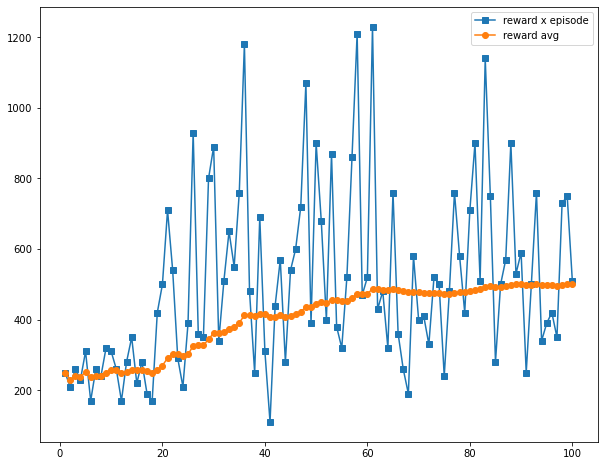

In [6]:
#Live plot of the 
#%matplotlib tk

#Inline the plot
%matplotlib inline

#Profile the run (optional)
#%load_ext line_profiler
#%lprun -f run run()

#Run without profiler
run()

# Scratch Pad

Visualize Pre-Processing

Timestep 0
Timestep 1
Timestep 2
Timestep 3


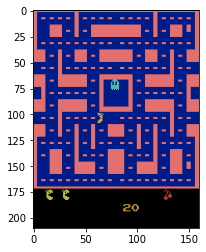

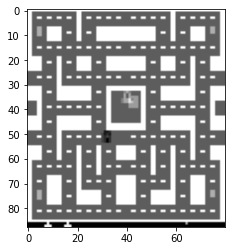

(210, 160, 3)
(1, 88, 80, 1)


In [6]:
%matplotlib inline

#Load the environment
env = gym.make("MsPacman-v0")
preprocess = PreProcessMSPacman(4)

#Reset the game
state = env.reset()   

#Skip waiting portion of the game
for i in range(90):
    env.step(0)   
    env.render()

#Play with some random motions
for i in range(4):    
    #Random sample motion
    state, reward, done, _ = env.step(env.action_space.sample()) # take a random action
    env.render()
    
    #Preprocess the state
    state_processed = preprocess.apply(state)                
    print("Timestep",i)
    if done:
        break;

#Plot the original state
plt.imshow(state, vmin=0, vmax=255)
plt.show()

#Plot the processed state
img = state_processed[0]

#plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.imshow(img, cmap='gray')
plt.show()

print(state.shape)
print(state_processed.shape)
      
#Close th environment
env.close()